https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

## [Keras 以 ResNet-50 預訓練模型建立狗與貓辨識程式](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)


https://stackoverflow.com/questions/42666046/loading-a-trained-keras-model-and-continue-training

--

## [Image Classifier - Cats🐱 vs Dogs🐶 - Leveraging Convolutional Neural Networks (CNNs) and Google Colab’s Free GPU](https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8)

## 關於 high validation score but poor test score on kaggle submission

### [test_generator的batch_size 和 predict_generator的steps : 解決可能造成預測機率與編號跑掉的原因(模型預設是32，原先我填入自定義的batch_size，現在改成1試試看)](https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator)

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
print(os.listdir("input/train")[0:10])

['cat.3406.jpg', 'cat.7660.jpg', 'dog.3144.jpg', 'cat.8235.jpg', 'cat.3360.jpg', 'dog.6982.jpg', 'dog.8777.jpg', 'cat.5711.jpg', 'cat.3374.jpg', 'dog.5247.jpg']


In [3]:
FAST_RUN = False
IMAGE_WIDTH = 224   #128
IMAGE_HEIGHT = 224   #128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# 影像類別數
NUM_CLASSES = 2
# 凍結網路層數
FREEZE_LAYERS = 2
# Epoch 數
NUM_EPOCHS = 25

In [4]:
# filenames = os.listdir("./kaggle_dogcat/train/train")
filenames = os.listdir("input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,cat.3406.jpg,0
1,cat.7660.jpg,0
2,dog.3144.jpg,1
3,cat.8235.jpg,0
4,cat.3360.jpg,0


In [6]:
df.tail()

,filename,category
3995,dog.7449.jpg,1
3996,cat.5708.jpg,0
3997,dog.2525.jpg,1
3998,dog.10205.jpg,1
3999,cat.2701.jpg,0


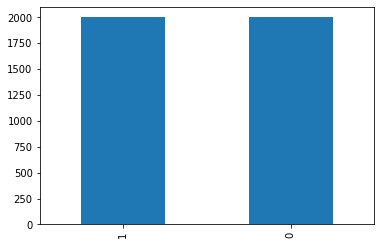

In [7]:
df['category'].value_counts().plot.bar()

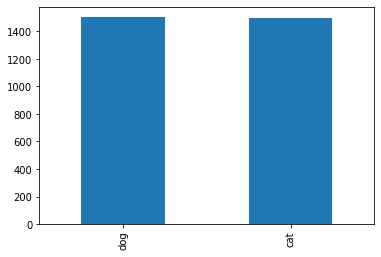

In [8]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.25, random_state=87)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

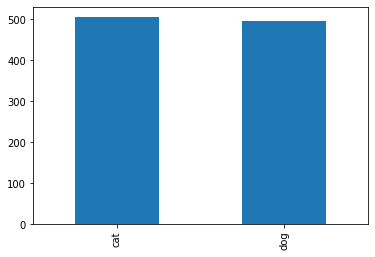

In [9]:
validate_df['category'].value_counts().plot.bar()

In [10]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 8 #15

In [11]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=10,
    horizontal_flip=True,
    fill_mode='nearest',
    
    # value used for fill_mode = "constant"
    cval=0.,
    # apply ZCA whitening
    zca_whitening=True,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06
)


# train_datagen = ImageDataGenerator(
    
#     # set rescaling factor (applied before any other transformation)
#     rescale = 1./255,
#     # set function that will be applied on each input
#     preprocessing_function=preprocess_input,
# #     interpolation = 'lanczos:random', # <--------- random crop


    
#     # set input mean to 0 over the dataset
#     featurewise_center=False,
#     # set each sample mean to 0
#     samplewise_center=False,
#     # divide inputs by std of dataset
#     featurewise_std_normalization=False,
#     # divide each input by its std
#     samplewise_std_normalization=False,
#     # apply ZCA whitening
#     zca_whitening=True,
#     # epsilon for ZCA whitening
#     zca_epsilon=1e-06,
#     # randomly rotate images in the range (deg 0 to 180)
#     rotation_range = 40,
#     # randomly shift images horizontally
#     width_shift_range = 0.2,
#     # randomly shift images vertically
#     height_shift_range = 0.2,
#     # set range for random shear
#     shear_range = 0.2,
#     # set range for random zoom
#     zoom_range = 0.3,
#     # set range for random channel shifts
#     channel_shift_range = 10,
#     # set mode for filling points outside the input boundaries
#     fill_mode='nearest',
#     # value used for fill_mode = "constant"
#     cval=0.,
#     # randomly flip images
#     horizontal_flip=True,
#     # randomly flip images
#     vertical_flip=False
# )




# #     # image data format, either "channels_first" or "channels_last"
# #     data_format=None,
# #     # fraction of images reserved for validation (strictly between 0 and 1)
# #     validation_split=0.0)


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/train",   #"./kaggle_dogcat/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = True # for train_generator & fit_generator : to prevent learning unnecessary info, such as the order of pictures
)

Found 3000 images belonging to 2 classes.


/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/train",  # "./kaggle_dogcat/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1000 images belonging to 2 classes.


Found 1 images belonging to 1 classes.


/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


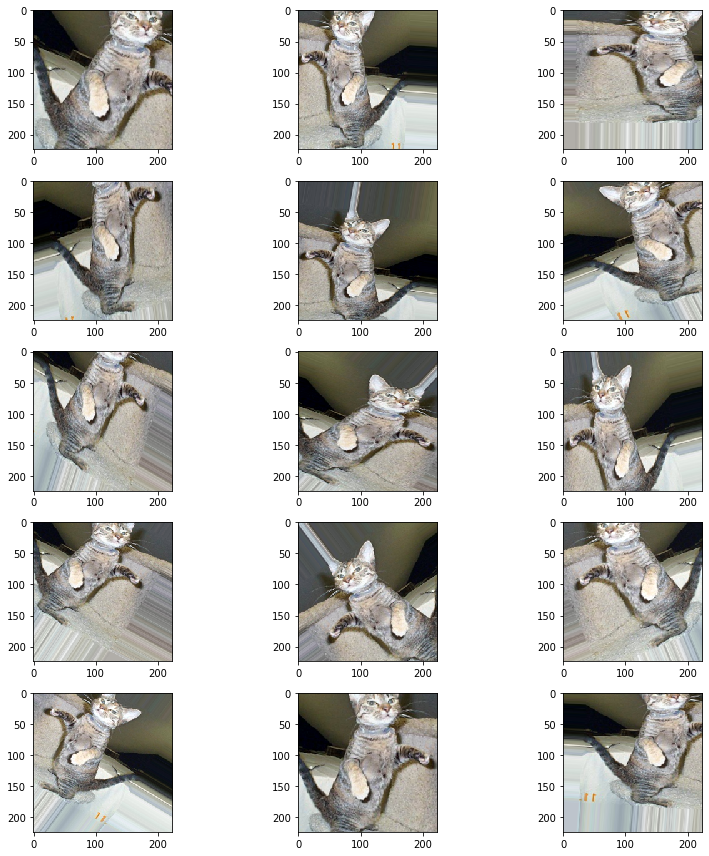

In [13]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input/train",  # "./kaggle_dogcat/train/train",  
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)


plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## [Day_086 - 使用 callbacks 函數儲存 model](https://github.com/jshuang0520/2nd-ML100Days/blob/master/homework/basic_PDF/Day_086.pdf)

## ModelCheckPoint

為何要使⽤ Model Check Point?

• ModelCheckPoint：自動將目前最佳的模型權重存下．假如電腦突然斷線、當機該怎麼辦? 難道我只能重新開始?

• 假如不幸斷線 : 可以重新自最佳的權重開始

• 假如要做 Inference :可以保證使⽤的是對 monitor metric 最佳的權重


--


    from keras.callbacks import ModelCheckpoint

    checkpoint = ModelCheckpoint('model.h5', # path to save
                                 monitor = 'val_acc', # target to monitor
                                 verbose = 1, # print infromation
                                 save_best_only = True) # save best checkpoint

    model.fit(x_train, y_train,
              epochs = EPOCHS,
              batch_size = BATCH_SIZE,
              validation_data = (x_test, y_test),
              shuffle = True,
              callbacks = [checkpoint])


## [Day_100 - Transfer Learning](https://github.com/jshuang0520/2nd-ML100Days/blob/master/homework/basic_PDF/Day_100.pdf)

- 資料量不足時，遷移學習也是很常見的⽅法

- 透過在其他龐⼤資料集上訓練好的模型參數，我們使⽤這個參數當成起始點，改⽤在⾃己的資料集上訓練！



## 為何以⽤遷移學習？

前面 CNN 的課程有提到，CNN 淺層的過濾器 (filter) 是用來偵測線條與顏⾊等簡單的元素。因此不管圖像是什麼類型，基本的組成應該要是⼀樣的

⼤型資料集 (如 ImageNet) 訓練好的參數具有完整的顏色、線條 filters，從此參數開始，我們訓練在⾃⼰的資料集中，逐步把 filters 修正為適合⾃自⼰資料集的結果。





## Transfer learning in Keras: ResNet-50 (1/3)

    from keras.applications.resnet50 import ResNet50

    resnet_model = ResNet50(input_shape = (224, 224, 3),
                            weights = 'imagenet',
                            pooling = 'avg',
                            include_top = False)


- 我們使用了 ResNet50 網路結構，其中可以看到 weights=”imagenet”，代表我們使⽤從 imagenet 訓練好的參數來初始化，並指定輸入的影像大小為 (224,224,3)

- pooling=avg 代表最後一層使用Global Average pooling，把 featuremaps 變成一維的向量

- include_top=False 代表將原本的 Dense layer 拔掉，因為原本這個網路路是用來做 1000 個分類的模型，我們必須替換成⾃己的 Dense layer 來來符合我們自己資料集的類別數量


## Transfer learning in Keras: ResNet-50 (2/3)

    last_featuremaps = resnet_model.output
    flatten_featuremap = Flatten()(last_featuremaps)
    output = Dense(num_classes)(flatten_featuremap)
    New_resnet_model = Model(inputs = resnet_model.input, outputs = output)


上⼀⾴的模型我們已經設定成沒有 Dense layers，且最後⼀層做 GAP，使用 resnet_model.output 我們就可以取出最後⼀層的 featuremaps 將其使⽤ Flatten 攤平後，再接上我們的 Dense layer，神經元數量與資料集的類別數量⼀致，重建立模型，就可以得到⼀個新的 ResNet-50 模型，且參數是根據 ImageNet 大型資料集預訓練好的


## Transfer learning in Keras: ResNet-50 (3/3)

[圖片來源：Github](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

整體流程如下圖，我們保留 Trained convolutional base，並新建 New classifier (Dense 的部分)，最後 convolutional base 是否要 frozen (不訓練) 則是要看資料集與預訓練的 ImageNet 是否相似，如果差異很⼤則建議訓練時不要 frozen，讓 CNN 的參數可以繼續更新


--

## 重要知識點複習

- 遷移學習是透過預先在大型資料集訓練好的權重，再根據⾃己的資料集進行微調 (finetune) 的⼀種學習⽅法

- Keras 中的模型，只要指定權重weights=”imagenet” 即可使用遷移學習


In [14]:
# try :
#     model.load_weights("model-ver7-resnet50_20190816-1100.h5")
#     print("載入模型成功，繼續訓練")
# except :
#     print("載入模型失敗，開始訓練新模型")

In [15]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3)) # 0.25

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3)) # 0.25

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3)) # 0.25

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3)) # 0.25

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# model.summary()



#-------------------------------------------------------------------------------------



# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())



# # 設定 callbacks - checkpoint
# from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('model-ver13-checkpoint-resnet50.h5', # path to save
#                              monitor = 'val_acc', # target to monitor
#                              mode='max',
#                              verbose = 1, # print infromation
#                              save_best_only = True) # save best checkpoint ; save_best_only = False 是儲存整個模型
# # callbacks設定
# callbacks = [checkpoint]

# 訓練模型
net_final_history = net_final.fit_generator(
                                train_generator,
                                steps_per_epoch = total_train // batch_size,
                                validation_data = validation_generator,
                                validation_steps = total_validate // batch_size,
                                epochs = NUM_EPOCHS,
                                shuffle=True)
                                # for train_generator & fit_generator : to prevent learning unnecessary info, such as the order of pictures




/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0818 14:36:09.807088 4797822400 deprecation.py:506] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

Epoch 1/25


/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1150: UserWarning:

375/375 [==============================] - 1425s 4s/step - loss: 1.0014 - acc: 0.6953 - val_loss: 1.4417 - val_acc: 0.4900
Epoch 2/25
375/375 [==============================] - 1405s 4s/step - loss: 0.4963 - acc: 0.8503 - val_loss: 0.3832 - val_acc: 0.8430
Epoch 3/25
375/375 [==============================] - 1395s 4s/step - loss: 0.4178 - acc: 0.8817 - val_loss: 0.1173 - val_acc: 0.9600
Epoch 4/25
375/375 [==============================] - 1437s 4s/step - loss: 0.3651 - acc: 0.8920 - val_loss: 0.1157 - val_acc: 0.9640
Epoch 5/25
375/375 [==============================] - 1401s 4s/step - loss: 0.3092 - acc: 0.9147 - val_loss: 0.0878 - val_acc: 0.9710
Epoch 6/25
375/375 [==============================] - 1400s 4s/step - loss: 0.2908 - acc: 0.9157 - val_loss: 0.0855 - val_acc: 0.9690
Epoch 7/25
375/375 [==============================] - 1675s 4s/step - loss: 0.2401 - acc: 0.9280 - val_loss: 0.0943 - val_acc: 0.9690
Epoch 8/25
375/375 [==============================] - 1437s 4s/step - los

In [16]:
# from keras.models import Sequential, load_model
# try :
#     model = load_model("model-ver7-resnet50_20190816-1100.h5")
#     print("載入模型成功，繼續訓練")
# except :
#     print("載入模型失敗，開始訓練新模型")

In [17]:
# # 模型輸出儲存的檔案
# WEIGHTS_FINAL = 'model-ver7-resnet50_20190816-2200_ver20190818-0230.h5'
# # 儲存訓練好的模型
# net_final.save(WEIGHTS_FINAL)

In [18]:
# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-ver13_resnet50.h5'
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

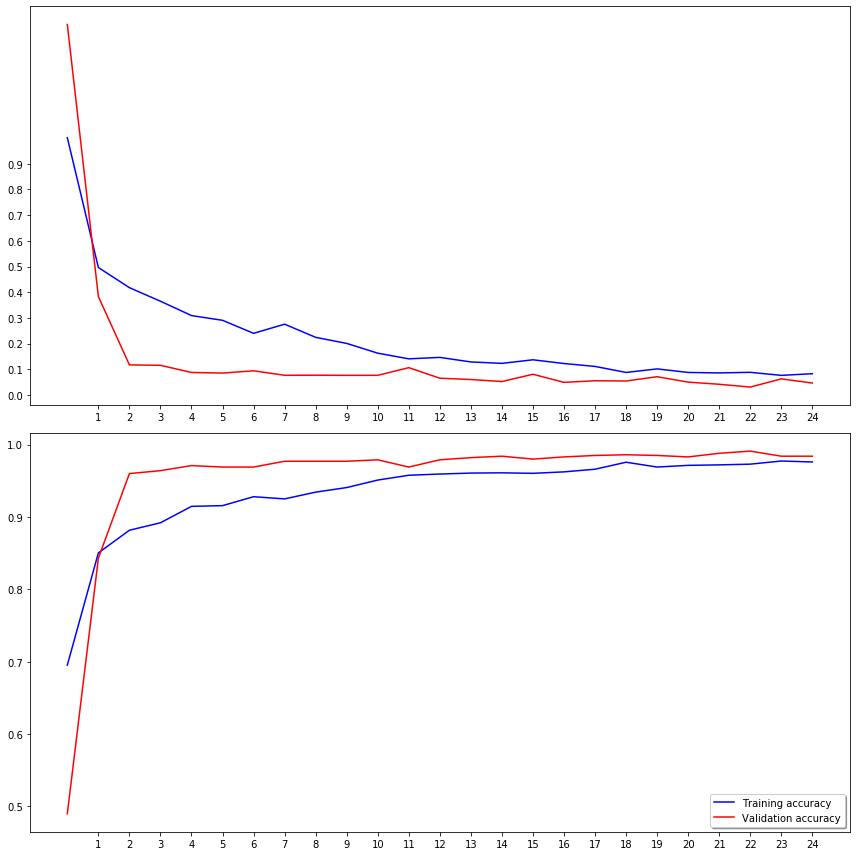

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(net_final_history.history['loss'], color='b', label="Training loss")
ax1.plot(net_final_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, NUM_EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(net_final_history.history['acc'], color='b', label="Training accuracy")
ax2.plot(net_final_history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, NUM_EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [20]:
# test_filenames = os.listdir("./kaggle_dogcat/test")
test_filenames = sorted(os.listdir("input/test"))
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input/test/",  # "./kaggle_dogcat/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size = 1, # test_generator的batch_size 和 predict_generator的steps : 解決可能造成預測機率與編號跑掉的原因(模型預設是32，原先我填入自定義的batch_size，現在改成1試試看) https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator
    shuffle=False
)

Found 400 images.


In [22]:
# predict = net_final.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict = net_final.predict_generator(test_generator, steps = nb_samples) # 解決可能造成預測機率與編號跑掉的原因 https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [23]:
label_map

{0: 'cat', 1: 'dog'}

In [24]:
# 因應 label_map 的對應關係
test_df['category'] = test_df['category'].replace({ 'dog': 0, 'cat': 1 })

In [25]:
validate_df.head()

,filename,category
0,cat.180.jpg,cat
1,cat.7210.jpg,cat
2,cat.10574.jpg,cat
3,dog.2656.jpg,dog
4,cat.6537.jpg,cat


In [26]:
# Y_val = validate_df['category']
# y_pred =  model.predict_generator(validation_generator)
# threshold = 0.5
# y_final = np.where(y_pred > threshold, 1,0)


# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# # Predict the values from the validation dataset

# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_val, y_final) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

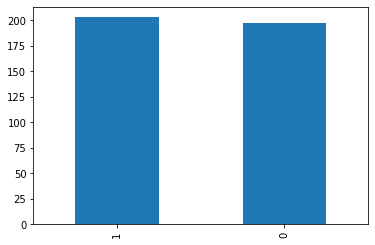

In [27]:
test_df['category'].value_counts().plot.bar()

In [28]:
# sample_test = test_df.head(18)
# sample_test.head()
# plt.figure(figsize=(12, 24))
# for index, row in sample_test.iterrows():
#     print("--- index --- : ", index)
#     print("--- row --- : ", row)
#     print("--- filename --- : ", filename, "\n")

    
    
#     filename = row['filename']
#     category = row['category']
#     img = load_img("input/test/"+filename, target_size=IMAGE_SIZE)
#     plt.subplot(6, 3, index+1)
#     plt.imshow(img)
#     plt.xlabel(filename + '(' + "{}".format(category) + ')' )
# plt.tight_layout()
# plt.show()

In [29]:
# # predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
# test_df['category'] = predict[:,0] # 因為我從頭就定義 cat 0, dog 1


# submission_df = test_df.copy()
# submission_df['id'] = submission_df['filename'].str.split('.').str[0]
# submission_df['Predicted'] = submission_df['category']
# submission_df.drop(['filename', 'category'], axis=1, inplace=True)

# submission_df = submission_df.sort_values(by=["id"]).reset_index(drop=True)

# submission_df.to_csv('submission_4-7_20190818-0230.csv', index=False)
# submission_df

In [30]:
test_df['category'] = predict[:,1] # cat 1, dog 0


submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

submission_df = submission_df.sort_values(by=["id"]).reset_index(drop=True)
# submission_df.to_csv('submission_4-7_20190818-0230.csv', index=False)
# submission_df.to_csv('submission_13_20190818-1330.csv', index=False)
submission_df

,id,Predicted
0,000,3.088338e-04
1,001,9.989041e-01
2,002,1.219494e-06
3,003,1.000000e+00
4,004,3.074797e-09
5,005,2.601537e-05
6,006,9.999995e-01
7,007,1.148689e-10
8,008,3.231308e-13
9,009,1.795618e-06


In [31]:
# from tensorflow.python.keras import backend as K
# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import Flatten, Dense, Dropout
# from tensorflow.python.keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# # 資料路徑
# DATASET_PATH  = 'input'

# # 影像大小
# IMAGE_SIZE = (224, 224)

# # 影像類別數
# NUM_CLASSES = 2

# # 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
# BATCH_SIZE = 8

# # 凍結網路層數
# FREEZE_LAYERS = 2

# # Epoch 數
# NUM_EPOCHS = 20

# # 模型輸出儲存的檔案
# WEIGHTS_FINAL = 'model-resnet50-final_20190816-1100.h5'

# # 透過 data augmentation 產生訓練與驗證用的影像資料
# train_datagen = ImageDataGenerator(rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    channel_shift_range=10,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')
# train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='categorical',
#                                                   shuffle=True,
#                                                   batch_size=BATCH_SIZE)

# valid_datagen = ImageDataGenerator()
# valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='categorical',
#                                                   shuffle=False,
#                                                   batch_size=BATCH_SIZE)

# # 輸出各類別的索引值
# for cls, idx in train_batches.class_indices.items():
#     print('Class #{} = {}'.format(idx, cls))

# # 以訓練好的 ResNet50 為基礎來建立模型，
# # 捨棄 ResNet50 頂層的 fully connected layers
# net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
#                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
# x = net.output
# x = Flatten()(x)

# # 增加 DropOut layer
# x = Dropout(0.5)(x)

# # 增加 Dense layer，以 softmax 產生個類別的機率值
# output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# # 設定凍結與要進行訓練的網路層
# net_final = Model(inputs=net.input, outputs=output_layer)
# for layer in net_final.layers[:FREEZE_LAYERS]:
#     layer.trainable = False
# for layer in net_final.layers[FREEZE_LAYERS:]:
#     layer.trainable = True

# # 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
# net_final.compile(optimizer=Adam(lr=1e-5),
#                   loss='categorical_crossentropy', metrics=['accuracy'])

# # 輸出整個網路結構
# print(net_final.summary())

# # 訓練模型
# net_final.fit_generator(train_batches,
#                         steps_per_epoch = train_batches.samples // BATCH_SIZE,
#                         validation_data = valid_batches,
#                         validation_steps = valid_batches.samples // BATCH_SIZE,
#                         epochs = NUM_EPOCHS)

# # 儲存訓練好的模型
# net_final.save(WEIGHTS_FINAL)

## [python - Can't reload a trained resnet50 model from a h5 file](https://www.oipapio.com/question-6567713)

    用 from tensorflow.python.keras import load_model
    來取代 # from keras.models import load_model

In [45]:
# import tensorflow.python.keras
from tensorflow.python.keras.models import load_model # from keras.models import load_model

try :
    new_model = load_model('model-ver13_resnet50.h5') # 上面設定 WEIGHTS_FINAL = 'model-ver13_resnet50.h5'，其實後來是存取整個模型欸 不只權重啦
    print("載入模型成功，繼續訓練")
except :
    print("載入模型失敗，開始訓練新模型")

載入模型成功，繼續訓練


In [47]:
# Callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


filepath = "model-ver13_resnet50_ver2-checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max',
                             save_weights_only=False) # save_weights_only=False To Save Full Model

callbacks = [earlystop, learning_rate_reduction, checkpoint]

# fit the model
# 訓練模型
new_model_history = new_model.fit_generator(
                                train_generator,
                                steps_per_epoch = total_train // batch_size,
                                validation_data = validation_generator,
                                validation_steps = total_validate // batch_size,
                                epochs = 20,
                                shuffle=True, # for train_generator & fit_generator : to prevent learning unnecessary info, such as the order of pictures
                                callbacks = callbacks)
                                

    

/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/johnsonhuang/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
374/375 [============================>.] - ETA: 3s - loss: 0.0678 - acc: 0.9749
Epoch 00001: val_acc improved from -inf to 0.98900, saving model to model-ver13_resnet50_ver2-checkpoint.h5
375/375 [==============================] - 1437s 4s/step - loss: 0.0676 - acc: 0.9750 - val_loss: 0.0535 - val_acc: 0.9890
Epoch 2/20
374/375 [============================>.] - ETA: 3s - loss: 0.0675 - acc: 0.9763
Epoch 00002: val_acc did not improve from 0.98900
375/375 [==============================] - 1378s 4s/step - loss: 0.0674 - acc: 0.9763 - val_loss: 0.0531 - val_acc: 0.9860
Epoch 3/20
374/375 [============================>.] - ETA: 3s - loss: 0.0600 - acc: 0.9809
Epoch 00003: val_acc did not improve from 0.98900
375/375 [==============================] - 1403s 4s/step - loss: 0.0602 - acc: 0.9807 - val_loss: 0.0578 - val_acc: 0.9860
Epoch 4/20
374/375 [============================>.] - ETA: 3s - loss: 0.0667 - acc: 0.9803
Epoch 00004: val_acc did not improve from 0.98900
375/375 [

In [48]:
# 儲存訓練好的模型
new_model.save('model-ver13_resnet50_ver2-model.h5')

In [62]:
# predict = net_final.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict = new_model.predict_generator(test_generator, steps = nb_samples) # 解決可能造成預測機率與編號跑掉的原因 https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [63]:
label_map

{0: 'cat', 1: 'dog'}

In [64]:
# 因應 label_map 的對應關係
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [65]:
validate_df.head()

,filename,category
0,cat.180.jpg,cat
1,cat.7210.jpg,cat
2,cat.10574.jpg,cat
3,dog.2656.jpg,dog
4,cat.6537.jpg,cat


In [66]:
test_df['category'] = predict[:,0] # cat 0, dog 1


submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

submission_df = submission_df.sort_values(by=["id"]).reset_index(drop=True)
# submission_df.to_csv('submission_13_20190818-1330_ver2.csv', index=False)
submission_df

,id,Predicted
0,000,1.000000e+00
1,001,9.999522e-01
2,002,1.000000e+00
3,003,1.794811e-15
4,004,1.000000e+00
5,005,1.000000e+00
6,006,2.936866e-07
7,007,1.000000e+00
8,008,1.000000e+00
9,009,1.000000e+00


## 用 剛剛 checkpoint 的結果來預測

In [80]:
# import tensorflow.python.keras
from tensorflow.python.keras.models import load_model # from keras.models import load_model

try :
    new_model = load_model('model-ver13_resnet50_ver2-checkpoint.h5') # 上面設定 WEIGHTS_FINAL = 'model-ver13_resnet50.h5'，其實後來是存取整個模型欸 不只權重啦
    print("載入模型成功，繼續訓練")
except :
    print("載入模型失敗，開始訓練新模型")

載入模型成功，繼續訓練


In [81]:
# predict = net_final.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict = new_model.predict_generator(test_generator, steps = nb_samples) # 解決可能造成預測機率與編號跑掉的原因 https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [82]:
label_map

{0: 'cat', 1: 'dog'}

In [83]:
# 因應 label_map 的對應關係
test_df['category'] = test_df['category'].replace(label_map)

In [84]:
test_df

,filename,category
0,000.jpg,cat
1,001.jpg,dog
2,002.jpg,cat
3,003.jpg,dog
4,004.jpg,cat
5,005.jpg,cat
6,006.jpg,dog
7,007.jpg,cat
8,008.jpg,cat
9,009.jpg,cat


In [85]:
validate_df.head()

,filename,category
0,cat.180.jpg,cat
1,cat.7210.jpg,cat
2,cat.10574.jpg,cat
3,dog.2656.jpg,dog
4,cat.6537.jpg,cat


In [86]:
test_df['category'] = predict[:,0] # cat 0, dog 1


submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

submission_df = submission_df.sort_values(by=["id"]).reset_index(drop=True)
# submission_df.to_csv('submission_13_20190818-1330_ver2-checkpoint_predict.csv', index=False)
submission_df

,id,Predicted
0,000,9.999082e-01
1,001,6.672581e-05
2,002,9.999548e-01
3,003,1.280232e-12
4,004,1.000000e+00
5,005,9.998150e-01
6,006,1.025814e-06
7,007,1.000000e+00
8,008,1.000000e+00
9,009,9.999598e-01


In [73]:
test_df['category'] = predict[:,0] # cat 0, dog 1


submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

submission_df = submission_df.sort_values(by=["id"]).reset_index(drop=True)
# submission_df.to_csv('submission_13_20190818-1330_ver2-checkpoint_predict.csv', index=False)
submission_df

,id,Predicted
0,000,9.999082e-01
1,001,6.672581e-05
2,002,9.999548e-01
3,003,1.280232e-12
4,004,1.000000e+00
5,005,9.998150e-01
6,006,1.025814e-06
7,007,1.000000e+00
8,008,1.000000e+00
9,009,9.999598e-01


## 用 第一版 model 的結果來預測

In [87]:
# # import tensorflow.python.keras
# from tensorflow.python.keras.models import load_model # from keras.models import load_model

# try :
#     new_model = load_model('model-ver13_resnet50.h5') # 上面設定 WEIGHTS_FINAL = 'model-ver13_resnet50.h5'，其實後來是存取整個模型欸 不只權重啦
#     print("載入模型成功，繼續訓練")
# except :
#     print("載入模型失敗，開始訓練新模型")

載入模型成功，繼續訓練


In [88]:
# # predict = net_final.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
# predict = new_model.predict_generator(test_generator, steps = nb_samples) # 解決可能造成預測機率與編號跑掉的原因 https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

# test_df['category'] = np.argmax(predict, axis=-1)

# label_map = dict((v,k) for k,v in train_generator.class_indices.items())
# test_df['category'] = test_df['category'].replace(label_map)



In [89]:
# label_map

{0: 'cat', 1: 'dog'}

In [90]:
# # 因應 label_map 的對應關係
# test_df['category'] = test_df['category'].replace(label_map)

In [91]:
# test_df

,filename,category
0,000.jpg,cat
1,001.jpg,dog
2,002.jpg,cat
3,003.jpg,dog
4,004.jpg,cat
5,005.jpg,cat
6,006.jpg,dog
7,007.jpg,cat
8,008.jpg,cat
9,009.jpg,cat


In [92]:
# validate_df.head()

,filename,category
0,cat.180.jpg,cat
1,cat.7210.jpg,cat
2,cat.10574.jpg,cat
3,dog.2656.jpg,dog
4,cat.6537.jpg,cat


In [95]:
# test_df['category'] = predict[:,0] # cat 0, dog 1


# submission_df = test_df.copy()
# submission_df['id'] = submission_df['filename'].str.split('.').str[0]
# submission_df['Predicted'] = submission_df['category']
# submission_df.drop(['filename', 'category'], axis=1, inplace=True)

# submission_df = submission_df.sort_values(by=["id"]).reset_index(drop=True)
# submission_df.to_csv('submission_13_20190818-1330_ver2-checkpoint_predict.csv', index=False)
# submission_df

,id,Predicted
0,000,9.996912e-01
1,001,1.095937e-03
2,002,9.999988e-01
3,003,3.313717e-15
4,004,1.000000e+00
5,005,9.999740e-01
6,006,4.774719e-07
7,007,1.000000e+00
8,008,1.000000e+00
9,009,9.999982e-01
